In [ ]:
# Things to do

# Create series of observations per day
#     Broadcast Date

# Basic stats on frequency distribution
#     Mean number of obs
#     Std dev
#     Range
#     Histogram w KDE
#     Rolling average?

# Assess stationarity
#     Augmented Dickey-Fuller test
#         https://machinelearningmastery.com/time-series-data-stationary-python/
# 
# Create correlogram - ACF, PACF
#     statssmodel.graphics.tsaplots.plot_acf(series)
# 
# Interpret correlograms
# 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [38]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
import shapely
import geopandas as gpd

In [ ]:
def convertGeometries(df):
    for i in list(df.index):
        geom_type = df.loc[i, 'GeometryType']
        geom = None
        if geom_type == 'Point':
            geom =shapely.geometry.Point(df.loc[i,'Coordinates'])
        elif geom_type == 'GeometryCollection':
            if df.loc[i,'Coordinates'][0] == df.loc[i,'Coordinates'][-1]:
                geom = shapely.geometry.Polygon(df.loc[i,'Coordinates'])
            else:
                geom = shapely.geometry.LineString(df.loc[i,'Coordinates'])
        df.loc[i, 'geometry'] = geom

In [49]:
df = pd.read_csv('https://raw.githubusercontent.com/robisoniv/navwarning-analysis/master/CleanedData.csv')
# df = df.sample(frac=0.05)
df = df.drop(columns=['Unnamed: 0'])
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BroadcastingDate'] = pd.to_datetime(df['BroadcastingDate'])
df['Coordinates'] = df['Coordinates'].apply(lambda c: eval(c))
convertGeometries(df)

In [5]:
gdf = gpd.GeoDataFrame(df)
gdf['centroid'] = gdf['geometry'].centroid

for i in list(gdf.index):
    gdf.loc[i, 'lon_centroid'] = list(gdf.loc[i, 'centroid'].coords[0])[0]
    gdf.loc[i, 'lat_centroid'] = list(gdf.loc[i, 'centroid'].coords[0])[1]

In [6]:
df_daily_broadcast = gdf.groupby('BroadcastingDate').count()[['Area']].rename(columns={'Area': 'count'})

In [12]:
type()

pandas.core.series.Series

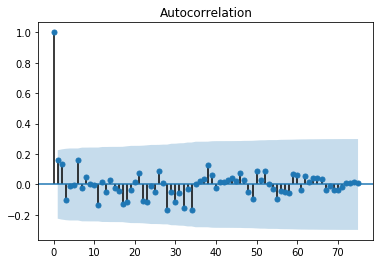

In [21]:
plot_acf(df_daily_broadcast['count'])
plt.show()

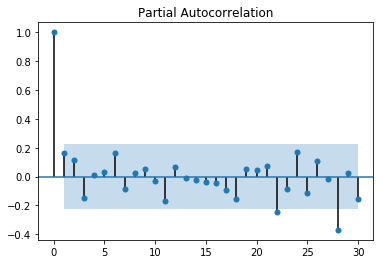

In [28]:
plot_pacf(df_daily_broadcast['count'], lags=30)
plt.show()

In [26]:
pacf = statsmodels.tsa.stattools.pacf(df_daily_broadcast['count'])

In [27]:
pacf

array([ 1.        ,  0.16173948,  0.11485455, -0.14785032,  0.01333293,
        0.03107511,  0.16497315, -0.08637675,  0.02595916,  0.05475222,
       -0.03214891, -0.1705442 ,  0.06334684, -0.00915907, -0.02210031,
       -0.03526795, -0.04370258, -0.09574841, -0.15707355,  0.05463062,
        0.04680656,  0.07120278, -0.24611117, -0.08470897,  0.16870422,
       -0.11404455,  0.1094035 , -0.0174848 , -0.36965884,  0.02726984,
       -0.15648269, -0.05931554, -0.34572116, -0.11884603, -0.36793572,
       -0.19776853,  0.06045902, -0.03385338,  0.48666416, -0.17637996,
       -0.16819245])

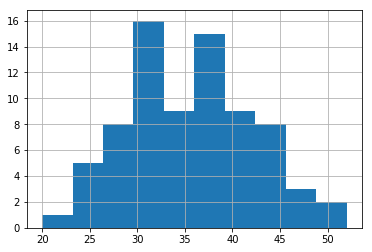

In [29]:
df_daily_broadcast['count'].hist()

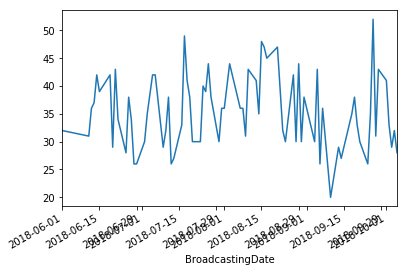

In [31]:
df_daily_broadcast['count'].plot()

In [44]:
# Adapted from https://machinelearningmastery.com/time-series-data-stationary-python/

def subsetSummaryStats(series):
    X = series.values
    split = int(len(X) / 3)
    X1, X2, X3 = X[0:split], X[split: split * 2], X[split * 2 :]
    mean1, mean2, mean3 = X1.mean(), X2.mean(), X3.mean()
    var1, var2, var3 = X1.var(), X2.var(), X3.var()
    print('mean1=%f, mean2=%f, mean3=%f' % (mean1, mean2, mean3))
    print('variance1=%f, variance2=%f, variance3=%f' % (var1, var2, var3))

In [45]:
subsetSummaryStats(df_daily_broadcast['count_log'])

mean1=3.514128, mean2=3.641930, mean3=3.501944
variance1=0.026985, variance2=0.024951, variance3=0.042107


In [39]:
df_daily_broadcast['count_log'] = np.log(df_daily_broadcast['count'])

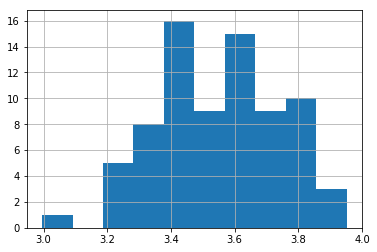

In [41]:
df_daily_broadcast['count_log'].hist()

In [48]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.203150
p-value: 0.000000
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
